#*TPS 08 Etchepareborda - Sistemas de recomendacion*

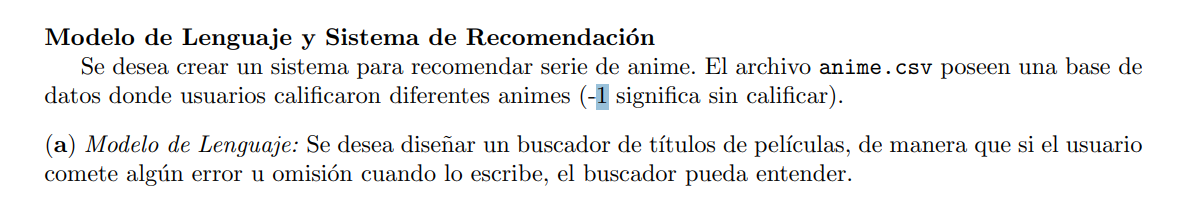

#*Importo las librerias necesarias*

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer


##*Importo los datos*

1. Cargar la base de datos anime.csv.

In [53]:
!curl -L -o anime.csv https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/anime.csv
data = pd.read_csv('anime.csv')
data.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.5M  100 13.5M    0     0  13.1M      0  0:00:01  0:00:01 --:--:-- 13.1M


,title,680973,682775,682809,684730,684840,684862,685362,686426,686489,...,1388155,1389510,1389679,1390094,1391050,1392101,1392278,1392522,1393478,1393558
0,"""Deji"" Meets Girl",-1.0,8.0,7.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,"""Ippon"" again!",-1.0,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,2.0,...,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0
2,"'Tis Time for ""Torture,"" Princess",-1.0,8.0,7.0,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,8.0,-1.0,6.0,-1.0,-1.0,6.0,-1.0
3,"'Tis Time for ""Torture,"" Princess Season 2",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0 Years Old Child Starting Dash Story,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


2. Cargar el modelo de lenguaje
El modelo de lenguaje posee una arquitectura transformer llamada XLM-Roberta. En lugar de trabajar palabra por palabra, este transformer utiliza subword tokens (utilizando la raız de las palabras con una perspectiva semantica).

In [54]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

3. Incorporar al modelo de lenguaje un procesamiento de texto que convierta mayusculas en minusculas y unifique espacios en blanco.

In [55]:
#Defino una funcion de preprocesamiento de texto
def preprocess_text(text):
    if isinstance(text, str):
        # Convertir a minúsculas y unificar espacios
        return ' '.join(text.lower().split())
    return ''

4. Computar el embedding de “Attack on Titan”. Indicar su dimension.

In [56]:
attack_on_titan = data[data['title'] == "Attack on Titan"]
print(attack_on_titan.shape)

original = "Attack on Titan"
preprocessed = preprocess_text(original)

emb_aot = model.encode(preprocessed)
emb_aot_np = model.encode(original)
print(f"Preprocesada {preprocessed} y shape {emb_aot.shape}")
print(f"No preprocesada {original} y shape {emb_aot_np.shape}")

(1, 1001)
Preprocesada attack on titan y shape (768,)
No preprocesada Attack on Titan y shape (768,)


Se ve que no cambia para esta string en particular

5. Se desea medir que tan parecidos son dos embeddings. Para ello, implementar un codigo que calcule
la similitud coseno. c: La similitud coseno se define como el coseno del angulo entre dos vectores
SC(u, v) = u·v
∥u∥∥v∥ .

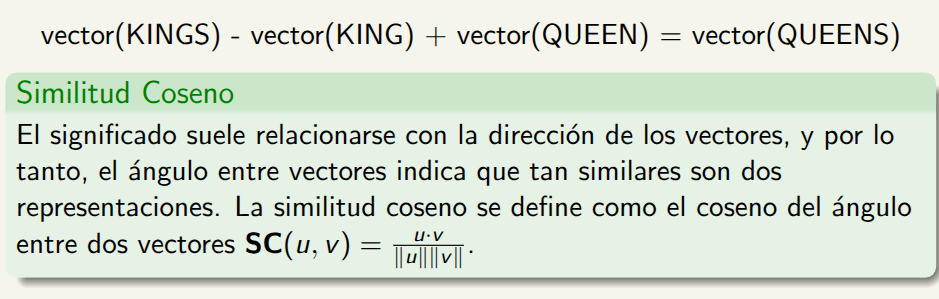

Cuanto mas cercano a uno (angulo exactamente igual, decimos que la similitud es maxima)

In [57]:
def similitud_coseno(u, v):
    try:
        num = np.dot(u, v)
        denom = np.linalg.norm(u) * np.linalg.norm(v)
        return num / denom
    except Exception as e:
        print("Error: u o v nulas o inválidas ->", e)
        return None
###Le armo un try catch por las dudas de que no se pueda hacer la cuenta, igual creo que numpy hace estos manejos por si solo

#En la api igualmente esta.
test_modelo = model.similarity(emb_aot,emb_aot_np)
test_mio = similitud_coseno(emb_aot,emb_aot_np)
print(test_modelo)
print(test_mio) ### Se ve que dan lo mismo (buena senal), no me queda claro de la consigna si hay que tomarlo de la API o si hay que calcularlo cada uno... Hago ambas por las dudas

tensor([[0.9740]])
0.97399366


6. Implementar un buscador que, dado un string (a partir de su correspondiente embedding), devuelva
las k series con una representacion mas similar.

In [58]:
def buscar_series(query, model, data, embeddings, k=5):
    """
    Busca las k series más similares a una consulta dada.
    """
    query = preprocess_text(query)
    # Hago el embedding del query
    query_emb = model.encode(query)

    # Calculo similitudes con todos los embeddings del dataset
    similitudes = np.array([similitud_coseno(query_emb, emb) for emb in embeddings])

    # Obtengo los índices de las k series más similares
    top_k_idx = np.argsort(similitudes)[::-1][:k]

    # Construyo un DataFrame con resultados
    resultados = data.iloc[top_k_idx][['title']].copy()
    resultados['similitud'] = similitudes[top_k_idx]

    return resultados.reset_index(drop=True)

7. Para verificar la caracterıstica semantica de los subword tokens, buscar la palabra “Giant” con
k = 15. Justificar resultados desde la perspectiva semantica.

In [59]:
#data['clean_text'] = data['title'].apply(lambda x: ' '.join(x.lower().split()) if isinstance(x, str) else '')
data['clean_text'] = data['title'].apply(preprocess_text)

# Genero los embeddings
embeddings = model.encode(data['clean_text'].tolist(), show_progress_bar=True)

# Uso el buscador.
query = "Giant"


resultados = buscar_series(query, model, data, embeddings, k=15)

print(resultados)


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

                     title  similitud
0            Giant Killing   0.656904
1      Giant Beasts of Ars   0.654885
2             SUPER HXEROS   0.552468
3               Megane-bu!   0.551769
4               Re:Monster   0.543036
5              Overlord II   0.541113
6                Megalobox   0.535180
7                Super Cub   0.534595
8                 Overlord   0.534339
9   The Great Warrior Wall   0.520100
10              Bullbuster   0.519549
11       Dragon Ball Super   0.515048
12            Heavy Object   0.509278
13          Plus-Sized Elf   0.489508
14         Tearmoon Empire   0.475996


### Análisis semántico con XLM-RoBERTa

En principio, según la consigna, el modelo tiene una arquitectura **Transformer XLM-RoBERTa**.  
Al utilizar la raíz de las palabras desde una **perspectiva semántica**, el modelo considera las **similitudes entre embeddings** de palabras que son semánticamente parecidas.

Como se vio en clase, se espera que palabras como **“Reyes”** y **“Corona”** tengan una alta coincidencia, al igual que pares como **“hombre – mujer”**, **“tío – tía”**, etc.

En este caso, al realizar la **query sobre “Giant”** desde una perspectiva semántica, se observan títulos que hacen referencia a conceptos relacionados con **grandeza**, **extremo**, **superioridad**, etc.

Las primeras coincidencias tienen sentido, ya que contienen la misma palabra (*“Giant”*) en el propio título.  
Sin embargo, las siguientes también presentan coherencia semántica:

- **Megane-bu!** → contiene la raíz *“Mega”*  
- **Megalobox** → también *“Mega”*  
- **Heavy Object** → *“Heavy”* (pesado)  
- **Re:Monster** → *“Monster”* (monstruo)  
- **SUPER HXEROS** → *“SUPER”*  
- **Great Teacher Onizuka**, entre otros  

En general, se observa que el modelo logra **captar la relación semántica** entre *“Giant”* y otros términos asociados con lo **grande**, **poderoso** o **extraordinario**.


8. Encapsular todo en una clase

In [60]:
class Buscador:
    def __init__(self, data):
        # Inicializa el modelo de lenguaje basado en transformadores multilingües.
        # Se utiliza este modelo para obtener representaciones semánticas de los textos.
        self.model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
        # Se conserva una copia del conjunto de datos original para evitar modificaciones sobre el original.
        self.data = data.copy()
        # Se aplica un preprocesamiento a los títulos con el fin de estandarizar el texto.
        self.data['clean_text'] = self.data['title'].apply(self.preprocess_text)
        # Durante la inicialización se calculan los embeddings del corpus completo.
        # Este proceso convierte cada título en un vector denso de representación semántica.
        print("Generando representaciones vectoriales del corpus...")
        self.embeddings = self.model.encode(self.data['clean_text'].tolist(), show_progress_bar=True)
        print("Embeddings generados correctamente.")
    def preprocess_text(self, text):
        # Función de preprocesamiento de texto.
        # Convierte todas las letras a minúsculas y unifica los espacios en blanco.
        if isinstance(text, str):
            return ' '.join(text.lower().split())
        return ''
    def similitud_coseno(self, u, v):
        # Calcula la similitud del coseno entre dos vectores u y v.
        # Esta medida se utiliza para determinar el grado de similitud semántica entre textos.
        try:
            num = np.dot(u, v)
            denom = np.linalg.norm(u) * np.linalg.norm(v)
            return num / denom
        except Exception as e:
            print("Error: u o v nulas o inválidas ->", e)
            return None
    def buscar_series(self, query, k=5):
        # Implementa el proceso de búsqueda semántica a partir de una consulta textual.
        # 1. Preprocesa el texto de entrada para garantizar coherencia con el corpus.
        # 2. Calcula el embedding del texto consultado.
        # 3. Evalúa la similitud del coseno entre la consulta y cada elemento del corpus.
        # 4. Ordena los resultados en función del grado de similitud.
        # 5. Devuelve las k series más cercanas semánticamente a la consulta.
        query_clean = self.preprocess_text(query)
        query_emb = self.model.encode(query_clean)
        similitudes = np.array([self.similitud_coseno(query_emb, emb) for emb in self.embeddings])
        top_k_idx = np.argsort(similitudes)[::-1][:k]
        resultados = self.data.iloc[top_k_idx][['title']].copy()
        resultados['similitud'] = similitudes[top_k_idx]
        return resultados.reset_index(drop=True)



In [61]:
# Carga del conjunto de datos
data = pd.read_csv("anime.csv")
# Creación de la instancia del buscador
#buscador = Buscador(data[['title']])
# Definición de la consulta
#query = "Attack on Titan"
# Ejecución de la búsqueda con la consulta dada
# Se solicita, por ejemplo, las 5 series más próximas semánticamente al término "Giant"
#resultados = buscador.buscar_series(query, k=15)
# Visualización de los resultados obtenidos
#print(resultados)


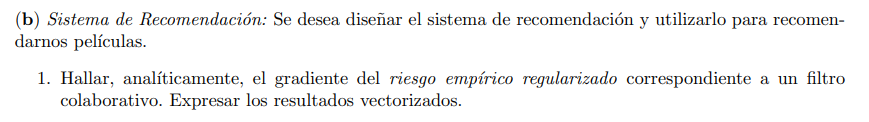

---

Esto me lo dejo para ver a mi, el filtro colaborativo tiene los x como los items (nxv) y los tita (n_user x v) como parametros a entrenar, v la dimension del espacio latente. Despues lambda termina siendo un hiperparametro de regularizacion.

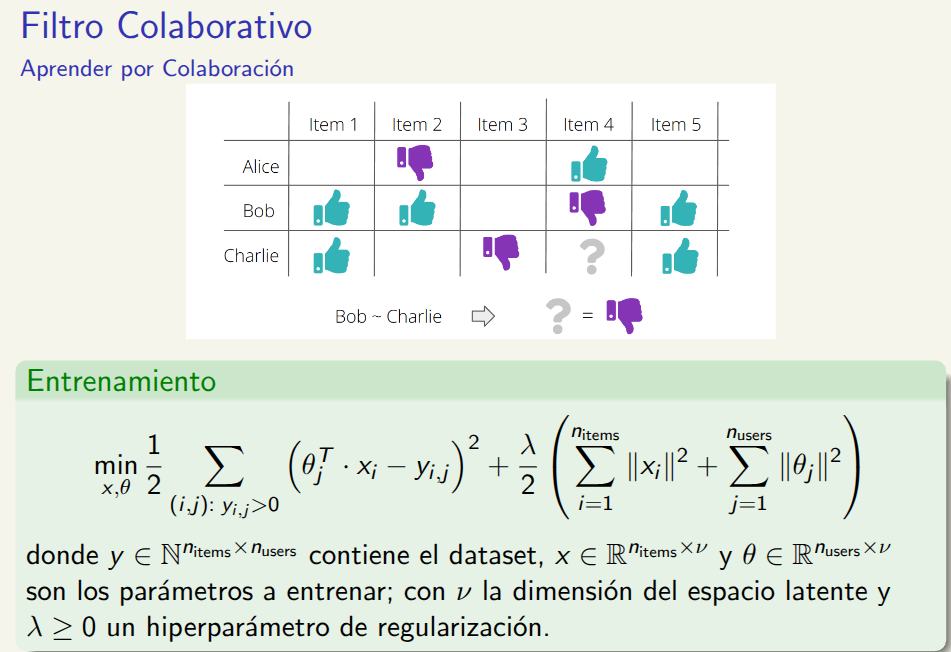
---


Despues, para la parte de inferencia (poner un nuevo rating), se toma la combinacion de los factores aprendidos durante el entrenamiento.

Termina quedando como

$$
  \hat{y}_{i,j} = p(\theta^T_j \cdot x_i) + (1-p)\overline{y_i}
$$
Donde $\overline{y_i}$ es la calificacion del item iesimo, p es un hiperparametro que indica cuanto peso le damos al aprendizaje y cuanto al valor medio del item que estamos considerando. (Pesa mas si a mas gente le viene gustando un titulo mas alla de las preferencias individuales)


---
Para plantear el problema de filtrado colaborativo sigo lo que esta en el video de Andrew Ng, plantea ambos problemas por separado primero:
Si yo tengo los ratings de los usuarios para las peliculas puedo aprender los parametros $V$ en un espacio latente que da idea de las features que mejor las pueden segmentar, por ejemplo romance,accion,etc para despues predecir un futuro rating de la mejor manera...


Si por otro lado yo tengo los vectores latentes de peliculas y tengo una tira de muestras sobre ratings de algunas peliculas de usuarios, tambien puedo aprender con respecto a los usuarios que diga que tanto le gusta una pelicula de accion, una de romance etc... en cualquiera de los dos casos yo despues cuando haga el promedio ponderado con los parametros aprendidos, voy a poder plantear cual va a ser el rating esperado para una pelicula k con ciertos parametros de accion, romance etc ... dado que al usuario i le gusta en diferente medida cada categoria. (El espacio latente propuesto es solo por interpretabilidad).

Ahora, el problema es que no se conoce con certeza ninguno de los dos parametros, ni las preferencias de los usuarios ni tampoco los parametros que describen de manera optima la segmentacion entre peliculas, por eso, se propone sumar ambas funciones de costo que son parecidas a un ajuste lineal con regularizacion y optimizar respecto a ambos parametros y esperando que converja luego de unos valores iniciales mediante gradiente descendiente.


Las derivadas respecto a cada uno de los parametros es constante respecto al otro, por eso se divide en dos ecuaciones.


# Sistema de Recomendación: Gradiente del Riesgo Empírico Regularizado

## 1. Planteamiento del problema

Se considera un **sistema de recomendación basado en filtrado colaborativo** mediante **factorización matricial**.

Sea  
$R \in \mathbb{R}^{m \times n}$ la matriz de calificaciones, donde:

- $m$: número de usuarios  
- $n$: número de películas  

Introducimos matrices latentes:

- $U \in \mathbb{R}^{m \times k}$ → vectores latentes de usuarios  
- $V \in \mathbb{R}^{n \times k}$ → vectores latentes de películas  

La predicción de la calificación del usuario $i$ para el ítem $j$ es:

$$
\hat{R}_{ij} = U_i \cdot V_j^T
$$

Se considera **regularización L2** para evitar sobreajuste.

El **riesgo empírico regularizado** se define como:

$$
L(U,V) = \frac{1}{2} \sum_{(i,j) \in \Omega} (R_{ij} - U_i \cdot V_j^T)^2
+ \frac{\lambda}{2} \left( \sum_{i=1}^{m} \|U_i\|^2 + \sum_{j=1}^{n} \|V_j\|^2 \right)
$$

donde:

- $\Omega$ es el conjunto de pares observados (usuario, ítem)  
- $\lambda > 0$ es el parámetro de regularización  


El primer sumando va a pesar las predicciones contra la realidad del usuario i contra todas las peliculas j. El segundo sumando tiene en cuenta la regularizacion de las preferencias promedio de cada uno de los usuarios y las peliculas que venian siendo consideradas.
Si la tendencia general entre usuarios es que les gusten los titulos, el modelo tiene en cuenta este factor mas que la combinacion especifica.


---

## 2. Gradiente analítico

### a) Con respecto a los vectores de usuarios $U_i$

$$
\frac{\partial L}{\partial U_i} = - \sum_{j \in \Omega_i} (R_{ij} - U_i \cdot V_j^T)V_j + \lambda U_i
$$

donde $\Omega_i$ es el conjunto de ítems calificados por el usuario $i$.

---

### b) Con respecto a los vectores de ítems $V_j$

$$
\frac{\partial L}{\partial V_j} = - \sum_{i \in \Omega_j} (R_{ij} - U_i \cdot V_j^T)U_i + \lambda V_j
$$

donde $\Omega_j$ es el conjunto de usuarios que calificaron el ítem $j$.

---

## 3. Forma vectorizada

Sea $M \in \mathbb{R}^{m \times n}$ la **máscara de observación**:

$$
M_{ij} =
\begin{cases}
1 & \text{si } R_{ij} \text{ está observado} \\
0 & \text{en caso contrario}
\end{cases}
$$

Definimos el **error**:

$$
E = M \odot (R - UV^T)
$$

donde $\odot$ denota la **multiplicación elemento a elemento**.

Los **gradientes vectorizados** se expresan como:

$$
\frac{\partial L}{\partial U} = -EV + \lambda U
$$

$$
\frac{\partial L}{\partial V} = -E^T U + \lambda V
$$


In [62]:
#print(data.head( ))

2. Agregar un usuario a la base de datos con al menos 10 series calificadas. Utilice el buscador para
no tener que escribir los tıtulos perfectos.

Uso los mismos que me da el buscador para calificar sobre mi nuevo usuario.
## 2. Agregar un nuevo usuario automáticamente con 10 series calificadas
El siguiente bloque:
- Usa el `Buscador` para obtener 10 series relacionadas semánticamente con una palabra clave.
- Crea un nuevo usuario.
- Le asigna calificaciones aleatorias entre 8 y 10.
- Inserta la información en la matriz `data`.

Lo hice asi esperando que despues en el punto 5 me recomiende cosas parecidas, el tema es que como el modelo de lenguaje solo busca relaciones semanticas entre los titulos, los parametros en el espacio latente no tienen nada que ver con esto, por lo que no es significativo. Los titulos que me recomendo deben ser parecidos por otros motivos a los que me dio el buscador (que es logico, porque si bien los titulos dan una idea del contenido de la serie, no es lo que los define ni tampoco los motivos por los cuales los usuarios los ratean alto o bajo).

In [64]:
nuevo_usuario_id = np.random.randint(9000000, 9999999)  # id aleatorio
palabra_clave = "Attack on titan"  # consulta semántica
num_series = 10          # cantidad de series a calificar

print(f"Buscando series relacionadas con: '{palabra_clave}' ...")
buscador = Buscador(data[['title']])

# === Busco series usando el modelo semántico ===
resultados = buscador.buscar_series(query = palabra_clave, k=num_series)

# === Creo la nueva columna para el usuario ===
if nuevo_usuario_id not in data.columns:
    data[nuevo_usuario_id] = -1

# === Asigno calificaciones aleatorias (entre 8 y 10)  para que me de una idea de que me recomiende cosas parecidas a attack on titan dado que estas me gustaron
for i, row in resultados.iterrows():
    titulo = row["title"]
    rating = round(np.random.uniform(8, 10), 0)  # calificación sin decimales
    mask = data["title"].str.lower() == titulo.lower()
    data.loc[mask, nuevo_usuario_id] = rating

# === Resultados
print(f"\n Usuario {nuevo_usuario_id} agregado correctamente.\n")
print("📺 Series calificadas:")
display(data.loc[data[nuevo_usuario_id] != -1, ["title", nuevo_usuario_id]])


Buscando series relacionadas con: 'Attack on titan' ...
Generando representaciones vectoriales del corpus...


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Embeddings generados correctamente.

 Usuario 9434838 agregado correctamente.

📺 Series calificadas:


,title,9434838
201,Attack on Titan,9
202,Attack on Titan Season 2,9
203,Attack on Titan Season 3,10
204,Attack on Titan Season 3 Part 2,8
205,Attack on Titan: Final Season,9
206,Attack on Titan: Final Season Part 2,8
207,Attack on Titan: Junior High,9
842,Giant Killing,9
2265,Space Battleship Tiramisu,9
2596,The Strongest Tank's Labyrinth Raids -A Tank w...,10


## 3. Entrenamiento de un filtro colaborativo con gradiente descendente

En esta sección se entrena un modelo de **factorización matricial** utilizando **gradiente descendente**.  
El objetivo es obtener representaciones latentes de **usuarios** y **series** en un espacio de dimensión `k = 15`.

Parámetros utilizados:
- Dimensión del espacio latente: **15**  
- Regularización λ = **10**  
- Learning rate = **1e-3**  
- Número de iteraciones = **2000**

Además, se normalizan las calificaciones al rango **[0, 1]** antes del entrenamiento.


In [ ]:
#data.head()

In [ ]:
#print(R)

Matriz de ratings: 2966 items x 1001 usuarios
Iteración 200/2000 - Pérdida: 17588.3011
Iteración 400/2000 - Pérdida: 17417.5214
Iteración 600/2000 - Pérdida: 17374.1618
Iteración 800/2000 - Pérdida: 17368.6188
Iteración 1000/2000 - Pérdida: 17367.1770
Iteración 1200/2000 - Pérdida: 17366.0326
Iteración 1400/2000 - Pérdida: 17364.9656
Iteración 1600/2000 - Pérdida: 17364.1654
Iteración 1800/2000 - Pérdida: 17363.6717
Iteración 2000/2000 - Pérdida: 17363.3794


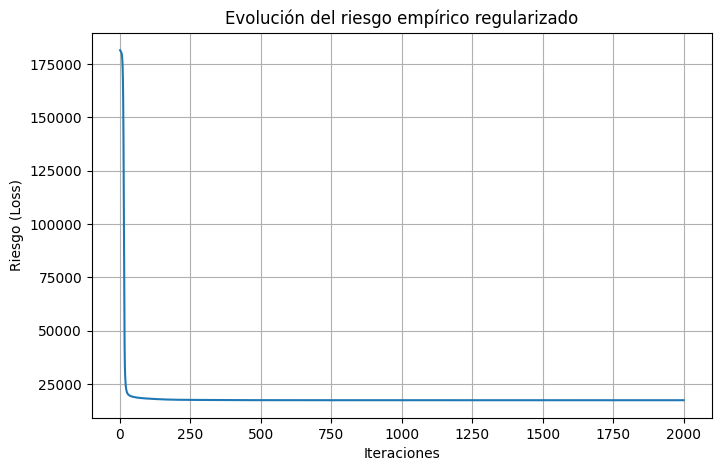

In [65]:
# ==========================================
# 1. Preparación de los datos numéricos
# ==========================================
# Se extrae la parte numérica del dataset, quitando la columna de títulos.
# Cada fila representa una serie y cada columna un usuario.
R = data.drop(columns=['title']).to_numpy(dtype=float)

# Se reemplazan los valores -1 (sin calificación) por 0.
R[R < 0] = 0

# Se normalizan las calificaciones al rango [0, 1].
R = R / R.max()

num_items, num_users = R.shape
print(f"Matriz de ratings: {num_items} items x {num_users} usuarios")

# ==========================================
# 2. Inicialización de parámetros
# ==========================================
# Dimensión del espacio latente
k = 15
# Parámetro de regularización
lmbda = 10
# Tasa de aprendizaje
lr = 1e-3
# Número de iteraciones del gradiente descendente
epochs = 2000

# Inicialización de las matrices latentes U (items) y V (usuarios)
np.random.seed(1)
U = np.random.normal(scale=0.1, size=(num_items, k))
V = np.random.normal(scale=0.1, size=(num_users, k))

# Se crea una máscara binaria para identificar las posiciones con ratings existentes.
mask = (R > 0).astype(float)

# ==========================================
# 3. Entrenamiento mediante gradiente descendente
# ==========================================
errores = []

for epoch in range(epochs):
    # Cálculo de la matriz de predicciones
    R_hat = U @ V.T

    # Error entre valores observados y predichos (solo en posiciones observadas)
    E = mask * (R - R_hat)

    # Cálculo de gradientes con término de regularización
    grad_U = -1 * E @ V +  lmbda * U
    grad_V = -1 * E.T @ U + lmbda * V

    # Actualización de los parámetros U y V
    U -= lr * grad_U
    V -= lr * grad_V

    # Cálculo del riesgo empírico regularizado
    loss = (np.sum((mask * (R - R_hat))**2) + lmbda * (np.sum(U**2) + np.sum(V**2)))/2
    errores.append(loss)

    # Mostrar el valor del error cada 200 iteraciones
    if (epoch + 1) % 200 == 0:
        print(f"Iteración {epoch + 1}/{epochs} - Pérdida: {loss:.4f}")

# ==========================================
# 4. Gráfico del riesgo empírico regularizado
# ==========================================
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), errores)
plt.title("Evolución del riesgo empírico regularizado")
plt.xlabel("Iteraciones")
plt.ylabel("Riesgo (Loss)")
plt.grid(True)
plt.show()


## 4. Crear un rating ponderado entre el filtro colaborativo y la calificación media

A partir del modelo entrenado en el punto anterior, se obtiene una estimación de la matriz de ratings `R_pred`.
Luego, se calcula la calificación media de cada serie (considerando solo las valoraciones existentes)
y se combina ambas fuentes en partes iguales.


In [66]:
# ======================================
# 1. Cálculo de la matriz de predicciones
# ======================================
# Se calcula la matriz de ratings predichos por el modelo colaborativo.
# Los valores ya se encuentran normalizados en el rango [0, 1].
R_pred = U @ V.T

# ======================================
# 2. Cálculo de la calificación media real
# ======================================
# Se utiliza la matriz original (sin normalizar) para obtener las medias reales de cada serie.
R_original = data.drop(columns=['title']).to_numpy(dtype=float)

# Se reemplazan los valores -1 (sin calificación) por NaN para excluirlos del cálculo de medias.
R_nan = np.where(R_original == -1, np.nan, R_original)

# Se calcula la media de cada serie, ignorando los valores faltantes.
media_series = np.nanmean(R_nan, axis=1)

# Se normalizan las medias al rango [0, 1] para mantener coherencia con R_pred.
media_series_norm = media_series / np.nanmax(media_series)

# ======================================
# 3. Creación del rating ponderado final
# ======================================
# Se expande el vector de medias a una matriz del mismo tamaño que R_pred.
media_matrix = np.tile(media_series_norm.reshape(-1, 1), R_pred.shape[1])

# Se calcula el promedio ponderado entre la predicción colaborativa y la media de cada serie.
# Ambas contribuyen en partes iguales (50% cada una).
R_final = 0.5 * R_pred + 0.5 * media_matrix

print("Rating ponderado calculado correctamente.")

# ======================================
# 4. Visualización de algunos ejemplos
# ======================================
# Se seleccionan aleatoriamente cinco series para comparar los valores obtenidos.
ejemplo = np.random.choice(len(data), 5, replace=False)

display(
    pd.DataFrame({
        "title": data.loc[ejemplo, "title"],
        "media_normalizada": np.round(media_series_norm[ejemplo], 3),
        "pred_colaborativo": np.round(R_pred[ejemplo, 0], 3),
        "rating_final": np.round(R_final[ejemplo, 0], 3)
    })
)


Rating ponderado calculado correctamente.


,title,media_normalizada,pred_colaborativo,rating_final
2241,Snow White with the Red Hair 2,0.751,0.577,0.664
2917,Yozakura Quartet: Hana no Uta,0.723,0.556,0.639
1617,Motto! Majime ni Fumajime Kaiketsu Zorori 2nd ...,0.525,0.238,0.381
452,Chaika -The Coffin Princess-,0.681,0.507,0.594
2614,The World God Only Knows II,0.754,0.582,0.668


## 5. Recomendación de las 10 películas no vistas con mayor rating

En este paso se utilizan los resultados ponderados del modelo (`R_final`) para recomendar al usuario creado
en el punto anterior las 10 series o películas con mayor puntuación estimada y que aún no haya calificado.


In [67]:
# ==========================
# Parámetros
# ==========================
# Se especifica el ID del usuario para el cual se generarán las recomendaciones.
usuario_objetivo = nuevo_usuario_id  # ID del usuario agregado en el punto 2

# ==========================
# 1. Identificación del índice del usuario
# ==========================nuevo_usuario_id
# Se obtienen las columnas correspondientes a los usuarios y se convierten a tipo entero.
usuarios = data.drop(columns=['title']).columns.astype(int)

# Se verifica que el usuario exista en el dataset.
if usuario_objetivo not in usuarios:
    raise ValueError(f"El usuario {usuario_objetivo} no existe en el dataset.")

# Se determina el índice de la columna correspondiente al usuario objetivo.
user_idx = np.where(usuarios == usuario_objetivo)[0][0]

# ==========================
# 2. Extracción de las calificaciones del usuario
# ==========================
# Se extraen todas las calificaciones del usuario especificado.
ratings_usuario = data[nuevo_usuario_id]
# ==========================
# 3. Filtrado de películas no vistas
# ==========================
# Se identifica qué títulos no fueron calificados por el usuario (valor -1).
no_vistas_mask = ratings_usuario == -1

# Se obtienen las predicciones correspondientes al usuario.
predicciones_usuario = R_final[:, user_idx]

# ==========================
# 4. Ordenamiento por rating ponderado
# ==========================
# Se ordenan las películas no vistas en función del rating predicho (de mayor a menor).
indices_ordenados = np.argsort(predicciones_usuario[no_vistas_mask])[::-1]

# Se seleccionan los índices de las 10 películas con mayor puntuación estimada.
top_10_idx = np.where(no_vistas_mask)[0][indices_ordenados[:10]]

# ==========================
# 5. Visualización de las recomendaciones
# ==========================
# Se construye un DataFrame con los títulos y sus ratings predichos.
recomendaciones = pd.DataFrame({
    "title": data.loc[top_10_idx, "title"].values,
    "rating_predicho": np.round(predicciones_usuario[top_10_idx], 3)
}).reset_index(drop=True)

print(f"Recomendaciones para el usuario {usuario_objetivo}:")
display(recomendaciones)


Recomendaciones para el usuario 9434838:


,title,rating_predicho
0,Frieren: Beyond Journey's End,0.638
1,Steins;Gate,0.621
2,Hunter x Hunter,0.618
3,Gintama Season 4,0.617
4,The Apothecary Diaries,0.611
5,Gintama Season 2,0.605
6,Gintama: Enchousen,0.601
7,Kaguya-sama: Love is War -Ultra Romantic-,0.601
8,Monogatari Series: Second Season,0.600
9,Vinland Saga Season 2,0.598


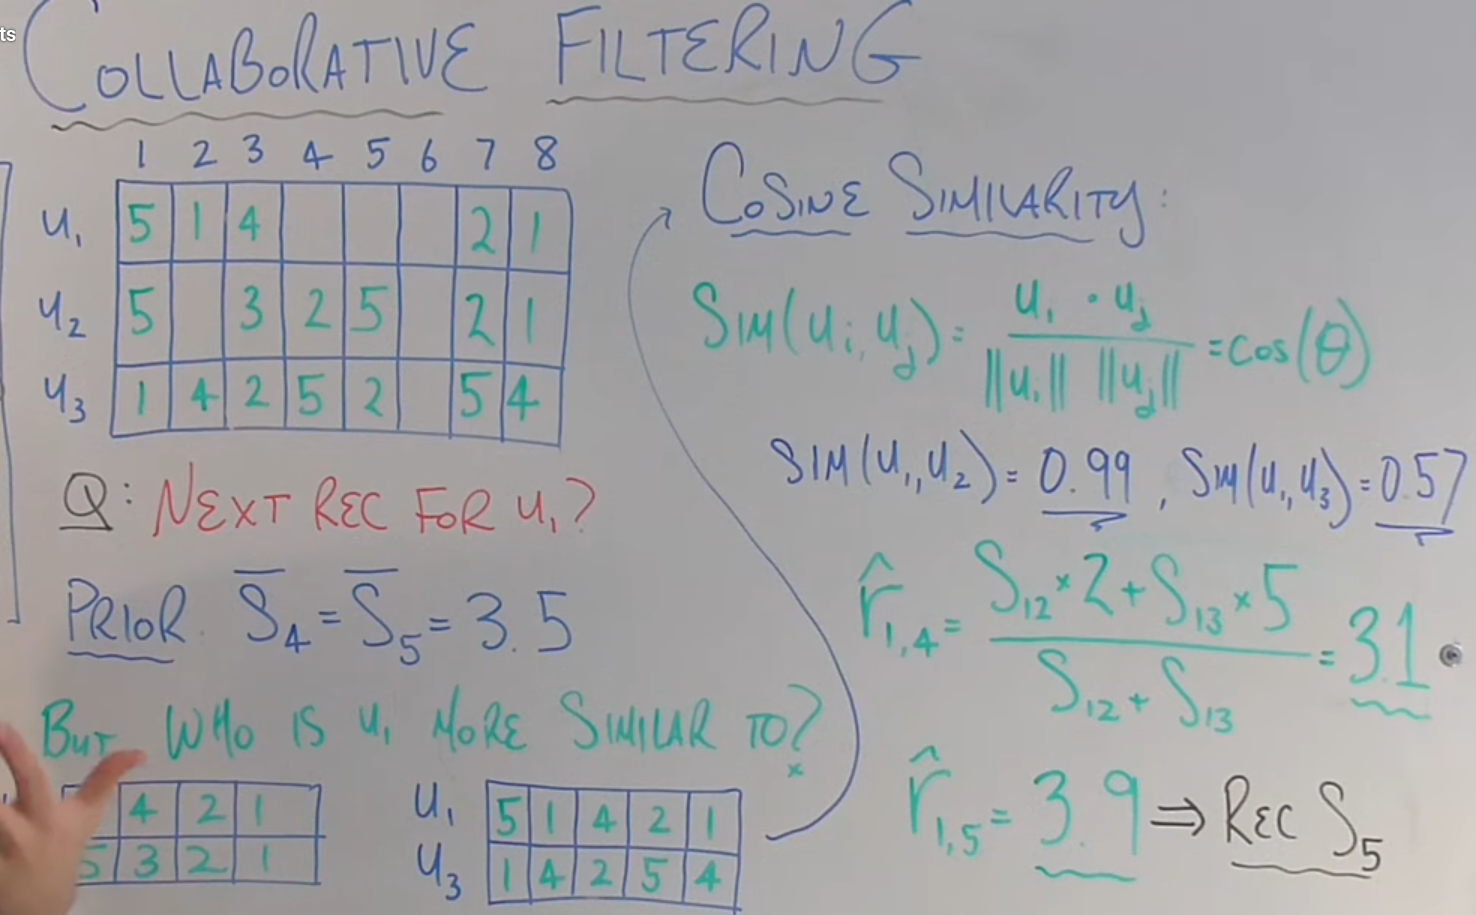

##**Comentario sobre modelo 0.5 + 0.5 + analisis cualitativo**
Al intentar usar solo con filtro colaborativo (sin darle peso a la media solo en funcion de los parametros aprendidos) en funcion de las recomendaciones del buscador con la palabra "Grand" los resultados fueron los siguientes.


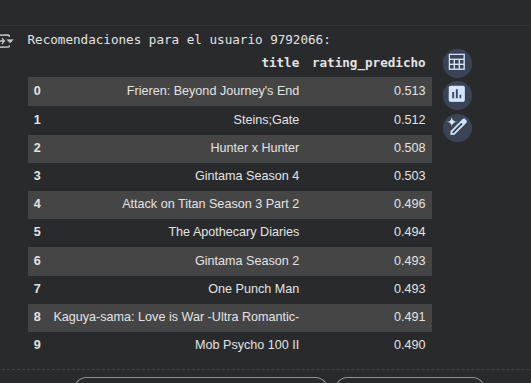





Parece que tomar un modelo de igual peso para ambos parametros termina influenciando en mucho mayor medida los promedios de las preferencias de otros usuarios.


Se terminan diluyendo las preferencias individuales y termina
aportando mucho mas peso los titulos que le gustaron al resto de los usuarios. Los titulos que no fueron calificados casi no se les da peso, esto es un problema cuando no hay muchas calificaciones por parte de un usuario nuevo.

No parecen ser suficientes 10 series similares semanticamente para que el modelo termine de entender que le gustan las series similares a "giant" porque esta colaboracion se hace con todos los otros titulos... Se termina diluyendo la preferencia por mas que sirva.

Ademas, los titulos que se tomaron para decir que eran buenos en formato a prueba (8 a 10) solo son parecidos semanticamente, no dice tanto sobre su contenido en si y las valoraciones que les dieron los otros usuarios. El espacio latente de los titulos aprendidos no debe tomar como feature de importancia el embedding del titulo.

Ademas, es probable que no funcione bien la recomendacion para este usuario porque no se lo puede meter en ningun cluster de usuarios parecidos (que les guste accion, que les guste romance que les guste thrillers etc. etc.), es un problema cuando no hay muchos ratings de un usuario i nuevo por lo que se lo termina dando a la media de las peliculas mejor rateadas. Probablemente funcione razonablemente bien si se lo prueba con un usuario real con preferencias que puedan ser agrupadas entre las que ya se encuentrar en el dataset.